# Does Sample Size affect distribution of expectation value?

### Basic Libraries

In [24]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer.noise import thermal_relaxation_error, ReadoutError, depolarizing_error

provider = IBMQ.get_provider(hub='ibm-q')
machine = provider.get_backend('ibmq_5_yorktown')
# from qiskit.test.mock import FakeLondon
# machine = FakeLondon()
machine_noise_model = NoiseModel.from_backend(machine)
simulator = Aer.get_backend('qasm_simulator')


basis_gates = machine_noise_model.basis_gates

C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-09-11 04:56:24,371: Credentials are already in use. The existing account in the session will be replaced.


In [2]:
machine

<FakeLondon('fake_london') from None()>

### Optimized Circuit

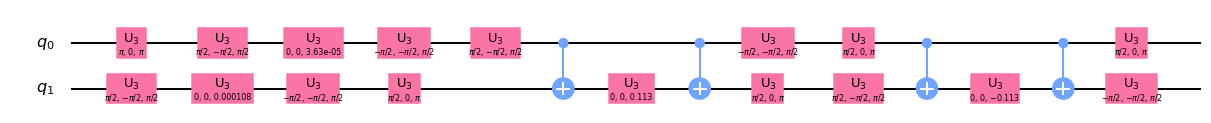

In [3]:
string = """OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nu3(pi,0,pi) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(0,0,3.6279236e-05) q[0];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[1];\nu3(0,0,0.00010816593) q[1];\nu3(-pi/2,-pi/2,pi/2) q[1];\nu3(pi/2,0,pi) q[1];\ncx q[0],q[1];\nu3(0,0,0.11268152) q[1];\ncx q[0],q[1];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,0,pi) q[0];\nu3(pi/2,0,pi) q[1];\nu3(pi/2,-pi/2,pi/2) q[1];\ncx q[0],q[1];\nu3(0,0,-0.11268152) q[1];\ncx q[0],q[1];\nu3(pi/2,0,pi) q[0];\nu3(-pi/2,-pi/2,pi/2) q[1];\n"""
vqe_circ = QuantumCircuit.from_qasm_str(string)
vqe_circ.draw(output = 'mpl')

### Hammyfication: Breaking Circuits into 2 copies, 1 for II, IZ, ZI and ZZ and the other for XX

In [4]:
from qiskit import ClassicalRegister
import math

Hamiltonian = """II
IZ 
ZI
ZZ
XX"""

Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]


circuits = []
for line in iter(Hamiltonian.splitlines()):
    circ = vqe_circ.copy()
    for index in range(len(line)):
        op = line[index]
        
        ##do nothing if Z or I
        if(op == "X"): 
            #hadamard in u3
            circ.u3(math.pi/2, 0, math.pi, index)
        elif(op == "Y"):
            circ.rx(pi/2, index)
    c = ClassicalRegister(2)
    circ.add_register(c)
    circ.measure([0], [0])
    circ.measure([1],[1])
    circuits.append(circ)

In [5]:
less_circuits = [circuits[0], circuits[4]]

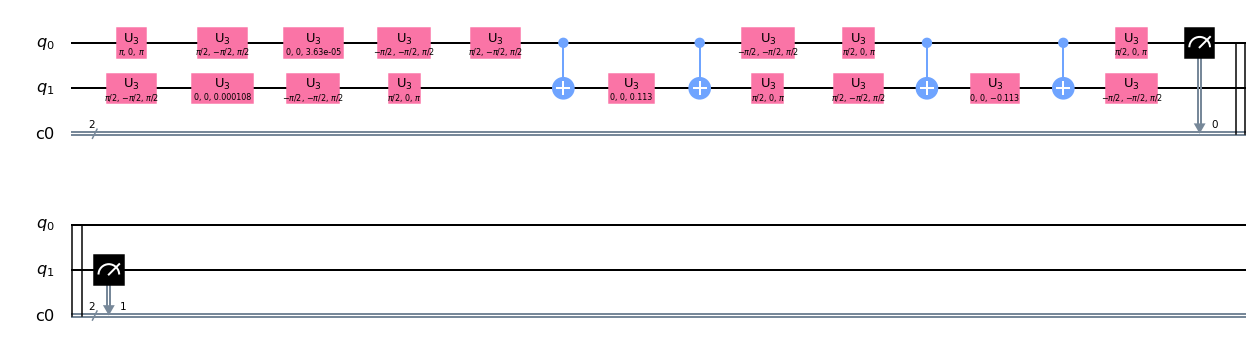

In [6]:
less_circuits[0].draw(output = 'mpl')

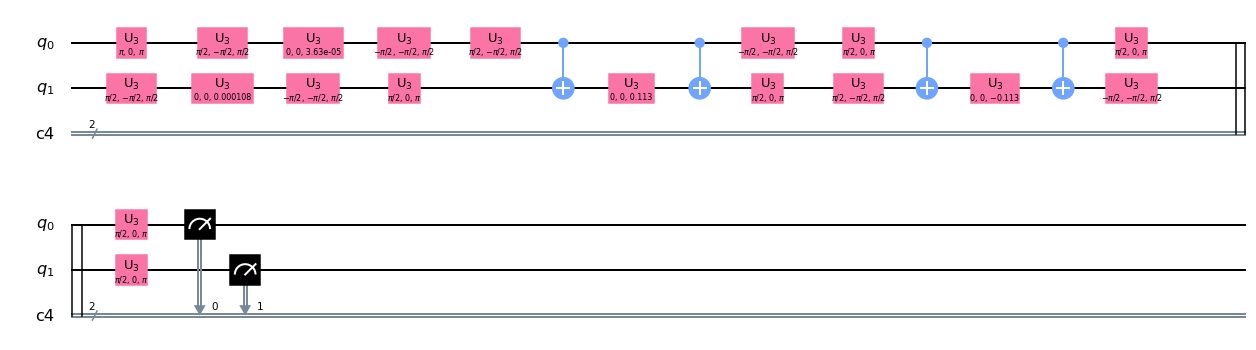

In [7]:
less_circuits[1].draw(output = 'mpl')
#hadamrd in u3 language

### Noise Amplification of Circuits

### Expectation Value Functions

In [8]:
def binaryToDecimal(binary):  
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal

In [9]:
def dictToList(dicty): 
    '''
    Converts dictionary to a list of keys appearing [frequency] number of times
    '''
    keys = dicty.keys()
    listy = []
    
    for key in keys: 
        listy += [key for i in range(dicty[key])]
    
    return listy

In [10]:
def sampleExpecVal(samp_zsis, samp_xx):
    '''
    Input: count corresponding to zz, zi, etc..., count corresponding to xx
    Output: expectation value of the sample
    '''
    
    #Hamiltonian = """II IZ ZI  ZZ XX"""
    Hamiltonian = ['ii', 'iz', 'zi', 'zz', 'xx' ]
    Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]
    Hamiltonian_eig = []
    
    for hammy in Hamiltonian: 
        if (hammy!= 'xx'): 
            Hamiltonian_eig+= [countToEig(samp_zsis, hammy)]
        else:
            Hamiltonian_eig+= [countToEig(samp_xx, hammy)]
            
    #combining eigvals of local hamiltonians 
    energy = np.dot(Hamiltonian_weights, Hamiltonian_eig)
    
    #add in the shift (nuclear repulsion energy)
    shift = 0.7151043390810812
    
    return energy + shift
    
    

In [11]:
import numpy as np
from qiskit.quantum_info import Pauli 

def countToEig(count, matrix): 
    '''
    Input: count (string), matrix (2 bit string)
    Output: eigval corresponding to that count
    '''
    
    #general matrices 
    x = [[0, 1],[1, 0]]
    z = [[1, 0], [0, -1]]
    i = [[1, 0],[0,1]]
    #parsing matrices
    matrices = []
    for mat in matrix: 
        if (mat== 'x'):
            matrices.append(x)
        elif(mat == 'z'):
            matrices.append(z)
        elif(mat == 'i'): 
            matrices.append(i)
        else: 
            print('Error parsing matrices')
    first = matrices[0]
    second = matrices[1]
#     print('Matrices are ')
#     print(first)
#     print(second)
    
    #computing eigenvalue of kron(first, second)
    v, w = np.linalg.eig(np.kron(first, second))
    #convert count to dec
    count = binaryToDecimal(int(count))
    return v[count]
          
            

In [12]:
import random

def expecValForSamples(counts_zsis, counts_xx):
    '''
    Input: counts [dict] for zz,iz, etc. , counts[dict] for xx
    Output: List of expecVal for all the samples
    '''
    
    #convert dict to list
    list_zsis = dictToList(counts_zsis)
    list_xx = dictToList(counts_xx)
    
    #extract samples from list and compute expec val
    expec_vals = []
    while(len(list_zsis)!= 0 and len(list_xx)!= 0): 
        index1 = random.randrange(0, len(list_zsis))
        index2 = random.randrange(0, len(list_xx))
        
        exp_val= sampleExpecVal(list_zsis[index1], list_xx[index2])
        expec_vals.append(exp_val)
        
        #removing those items from list 
        list_zsis.pop(index1)
        list_xx.pop(index2)
    return expec_vals
    

In [13]:
def addDicts(listy): 
    '''
    Input: list of dicts of counts 
    Output: combining all dicts into one dict, returning that
    '''
    keys = ['00', '11', '10', '01']
    master = {}
    
    for key in keys: 
        #initializing master at that key
        master[key] = 0
        
        #now adding up all dictys[key]
        for dicty in listy: 
            try:
                master[key] += dicty[key]
            except KeyError: 
                continue
    return master
            

### Running Circuits

In [14]:
# from qiskit.providers.aer.noise import NoiseModel
# from qiskit.aqua import QuantumInstance
# from qiskit.providers.aer.noise import thermal_relaxation_error, ReadoutError, depolarizing_error

# provider = IBMQ.get_provider(hub='ibm-q')
# machine = provider.get_backend('ibmq_london')
# noise_model = NoiseModel.from_backend(machine)
# simulator = Aer.get_backend('qasm_simulator')
# noisy_sim = QuantumInstance(backend = simulator, noise_model = noise_model)

# basis_gates = noise_model.basis_gates

#### Running Function

In [28]:
def evaluator(circuits, samples):
    """
    Input: circuits, noise model to run on , weights of the local hammys
    Output: expectation value (energy)
    
    """
    
    #Running the circuits 
    results = [[] for i in range(len(circuits))]
    noise_model = machine_noise_model
  
    
    
    while(samples!=0):
        if (samples>8192):
            for i_circ in range(len(circuits)):
                circ = circuits[i_circ]
                job =  execute(circ, backend = machine, shots = 8192)
                counts = job.result().get_counts()
                results[i_circ].append(counts)
            samples-= 8192
        else: 
            for i_circ in range(len(circuits)):
                circ = circuits[i_circ]
                job =  execute(circ, backend = machine,  shots = samples)
                counts = job.result().get_counts()
                results[i_circ].append(counts)
            samples = 0
    print('Running Circuits done')
    #adding up all the dicts
    counties = [addDicts(circ_results) for circ_results in results]
    
    print('Adding dicts done')
    #computing expectation values
    expec_vals = expecValForSamples(counties[0], counties[1])
    print('Computing expec vals done')
        
    return expec_vals
    

In [29]:
less_circuits

In [30]:
samples = [400*i for i in range(25)]
results= []

for sample in samples: 
    print('------------------ Sample ' + str(sample) + ' ---------------------------')
    result = evaluator(less_circuits, sample)
    results.append(result)


------------------ Sample 0 ---------------------------
Running Circuits done
Adding dicts done
Computing expec vals done
------------------ Sample 400 ---------------------------
Running Circuits done
Adding dicts done
Computing expec vals done
------------------ Sample 800 ---------------------------
Running Circuits done
Adding dicts done
Computing expec vals done
------------------ Sample 1200 ---------------------------
Running Circuits done
Adding dicts done
Computing expec vals done
------------------ Sample 1600 ---------------------------
Running Circuits done
Adding dicts done
Computing expec vals done
------------------ Sample 2000 ---------------------------
Running Circuits done
Adding dicts done
Computing expec vals done
------------------ Sample 2400 ---------------------------
Running Circuits done
Adding dicts done
Computing expec vals done
------------------ Sample 2800 ---------------------------
Running Circuits done
Adding dicts done
Computing expec vals done
-----

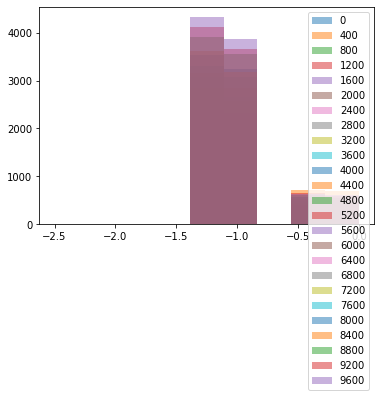

In [31]:
import random
import numpy
from matplotlib import pyplot


bins = numpy.linspace(-2.5, 0, 10)

for i in range(len(samples)):
    pyplot.hist(results[i], bins, alpha=0.5, label=samples[i])

pyplot.legend(loc='upper right')
pyplot.show()

In [32]:
means = []
errses = []

for i in range(len(samples)): 
    mean = np.mean(results[i])
    err = np.std(results[i])/np.sqrt(samples[i])
    means.append(mean)
    errses.append(err)


C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No handles with labels found to put in legend.


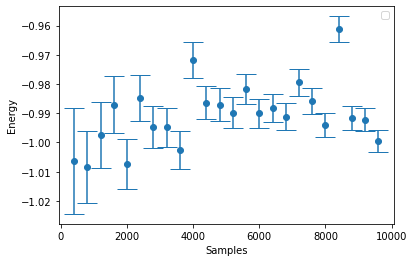

In [33]:
import matplotlib.pyplot as plt

a = plt.figure()
plt.errorbar(samples, means, yerr=errses,capsize = 10, fmt ='o')
#plt.plot(samples, [-1.137 for i in range(len(samples))], linestyle = '--', color = 'black', label = 'Exact Energy')
plt.xlabel('Samples')
plt.ylabel('Energy')
plt.legend()
plt.show()
a.savefig("Sept11(1).png", dpi = 1000)